In [65]:
import pandas as pd
import numpy as np
import datetime
pd.set_option('display.max_rows', 100)
import plotly.offline as offline


%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
import world_bank_data as wb

countries = wb.get_countries()

# population = wb.get_series('SP.POP.TOTL', mrv=1)  # Most recent value
population = wb.get_series('SP.POP.TOTL', id_or_value='id', simplify_index=True, mrv=1)

# Aggregate region, country and population
df_population = countries[['region', 'name']].rename(columns={'name': 'country'}).loc[countries.region != 'Aggregates']
df_population['population'] = population
df_population['country'] = df_population['country'].astype('string')
df_population['iso_code'] = df_population.index
df_population.loc[df_population.country =='Germany'].head(1)

,region,country,population,iso_code
id,,,,
DEU,Europe & Central Asia,Germany,82905782.0,DEU


In [2]:
path_to_owid = "/Users/chekanskiy/Documents/projects/covid-19-data"df_population

In [238]:
df_owid = pd.read_csv(f"{path_to_owid}/public/data/owid-covid-data.csv")
df_owid.head(1)

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
0,ABW,Aruba,2020-03-13,2,2,0,0,18.733,18.733,0.0,0.0,NaN,NaN,NaN,NaN,NaN


In [239]:
print(len(df_owid["iso_code"].unique()))

210


In [240]:
max_date = max(df_owid.date)
max_date

'2020-05-05'

In [243]:
df_owid_latest = df_owid[df_owid.date == df_owid.groupby('iso_code')['date'].transform('max')]
len(df_owid_latest)

209

In [244]:
set(df_owid.loc[df_owid.date == max_date]["iso_code"].unique()) - set(df_owid_latest.iso_code)

{nan}

## Join World bank Data and OWID Data

In [40]:
df_owid_latest.set_index('iso_code', inplace=True, drop=True)
df_owid_wb = df_population.join(df_owid_latest, how='inner')

In [44]:
df_owid_wb.head(1)

,region,country,population,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,new_deaths_per_million,total_tests,new_tests,total_tests_per_thousand,new_tests_per_thousand,tests_units
ABW,Latin America & Caribbean,Aruba,105845.0,ABW,Aruba,2020-05-05,100,0,2,0,936.628,0.0,18.733,0.0,NaN,NaN,NaN,NaN,NaN


# Cases per Million

In [196]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = "total_cases_per_million"
wld_count = df_owid_wb['total_cases'].sum() / (population.loc['WLD'] / 1000000)

level1 = df_owid_wb.loc[:, ['region', 'country', column_to_display]].copy()
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))

total_cases = df_owid_wb.groupby('region')['total_cases'].sum().reset_index().set_index('region')
mil_pop = (df_owid_wb.groupby('region')['population'].sum() / 1000000).reset_index().set_index('region', drop=False)
region_cases_per_mil = mil_pop.join(total_cases)
region_cases_per_mil['total_cases_per_million'] = region_cases_per_mil['total_cases'] / region_cases_per_mil['population'] 
level2 = region_cases_per_mil[['region', 'region', 'total_cases_per_million']]
level2.columns = columns
level2['parents'] = 'World'

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0
# level2.head(1)

level3 = pd.DataFrame({'parents': [''], 'labels': ['World'],
                       'values': [0.0], 'text': ['{:,.0f}'.format(wld_count)]})
# level3.head(1)

all_levels = pd.concat([level1, level2, level3], axis=0).reset_index(drop=True)
# all_levels

/Users/chekanskiy/Documents/projects/covid-19-exploration/venv/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



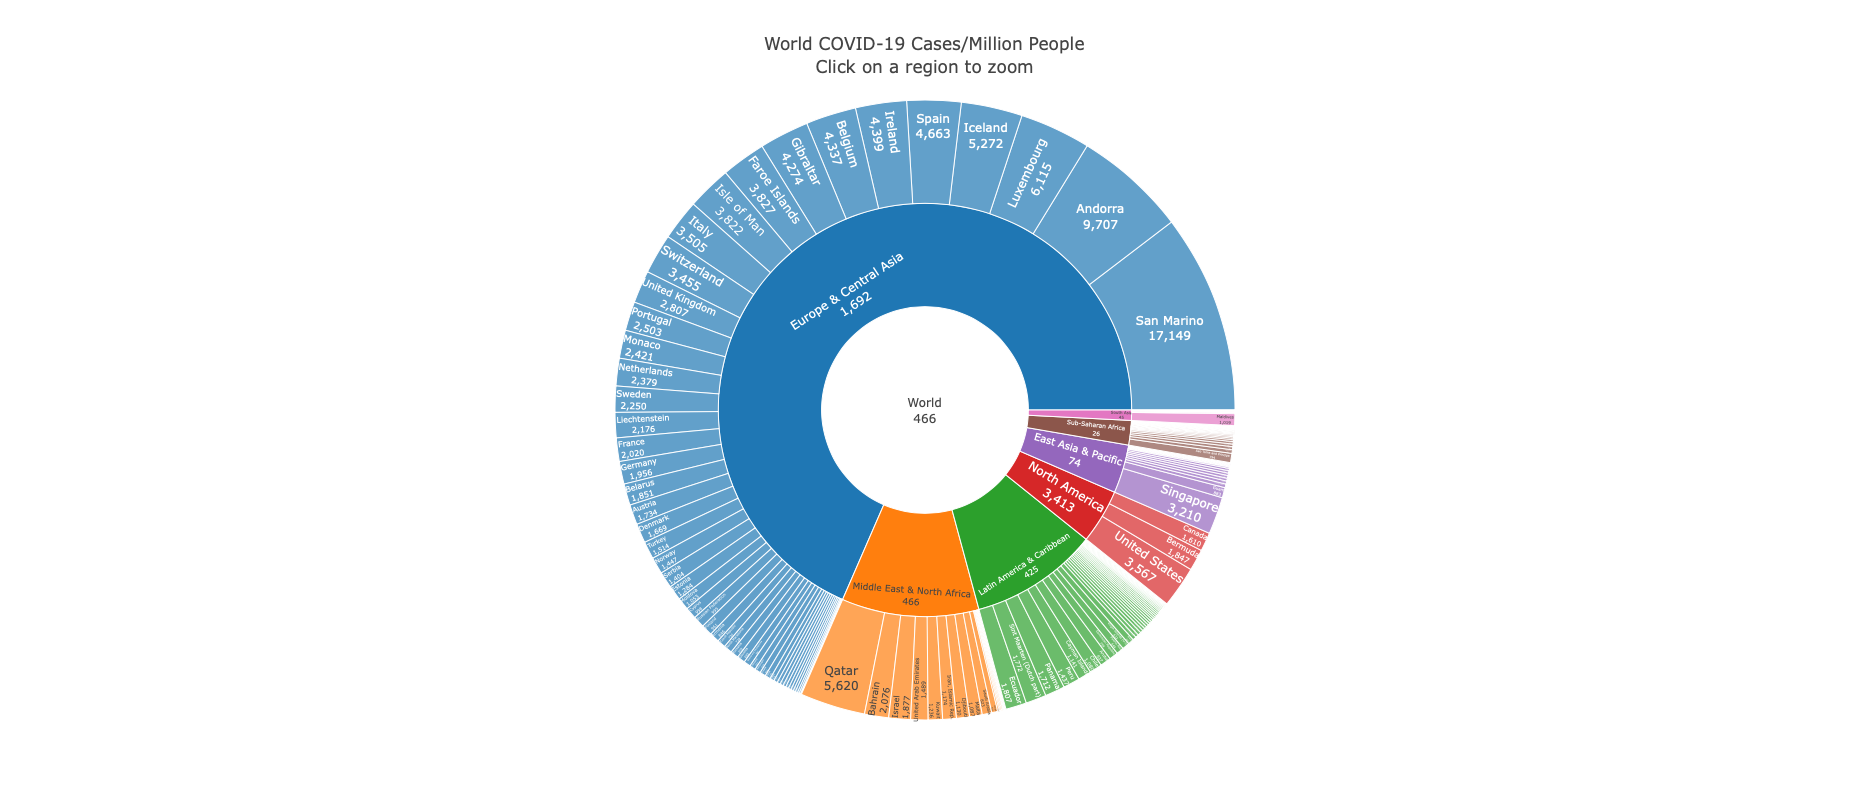

In [197]:
# And now we can plot the World Population
offline.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 Cases/Million People<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)

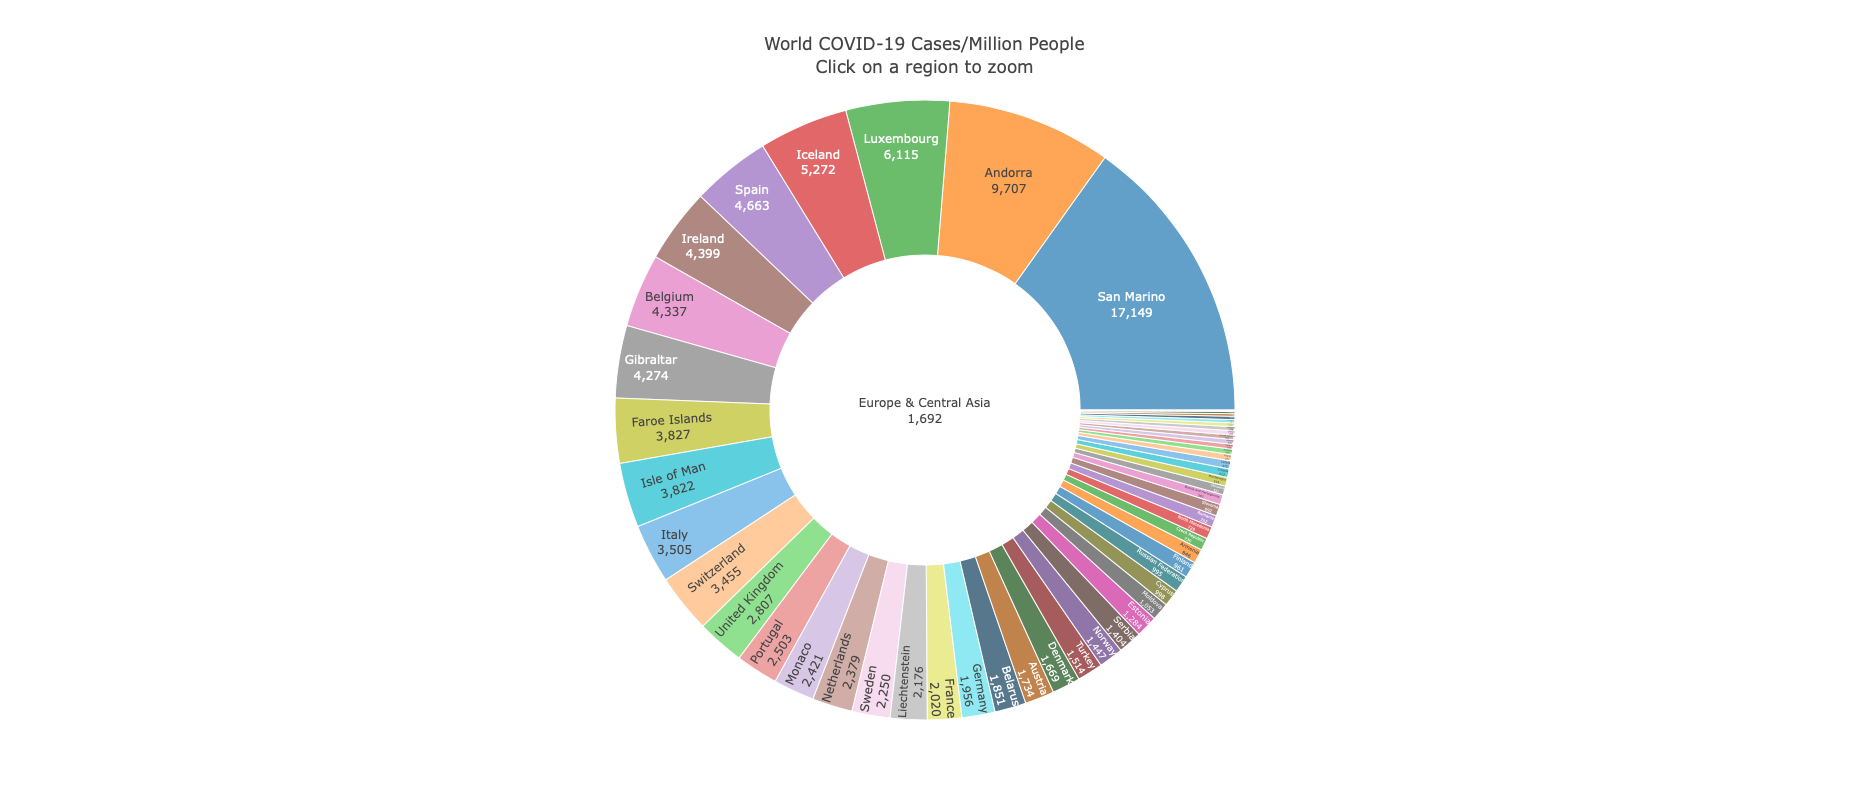

In [204]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = "total_cases_per_million"
wld_count = df_owid_wb['total_cases'].sum() / (population.loc['WLD'] / 1000000)

level1 = df_owid_wb.loc[df_owid_wb.region == 'Europe & Central Asia', ['region', 'country', column_to_display]].copy()
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))

total_cases = df_owid_wb.groupby('region')['total_cases'].sum().reset_index().set_index('region')
mil_pop = (df_owid_wb.groupby('region')['population'].sum() / 1000000).reset_index().set_index('region', drop=False)
region_cases_per_mil = mil_pop.join(total_cases)
region_cases_per_mil['total_cases_per_million'] = region_cases_per_mil['total_cases'] / region_cases_per_mil['population'] 
level2 = region_cases_per_mil[['region', 'region', 'total_cases_per_million']]
level2.columns = columns
level2 = level2.loc[level2.labels == 'Europe & Central Asia', :]
level2['parents'] = ''

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0

all_levels = pd.concat([level1, level2], axis=0).reset_index(drop=True)
# all_levels

# And now we can plot the World Population
offline.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 Cases/Million People<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)

# Total Cases

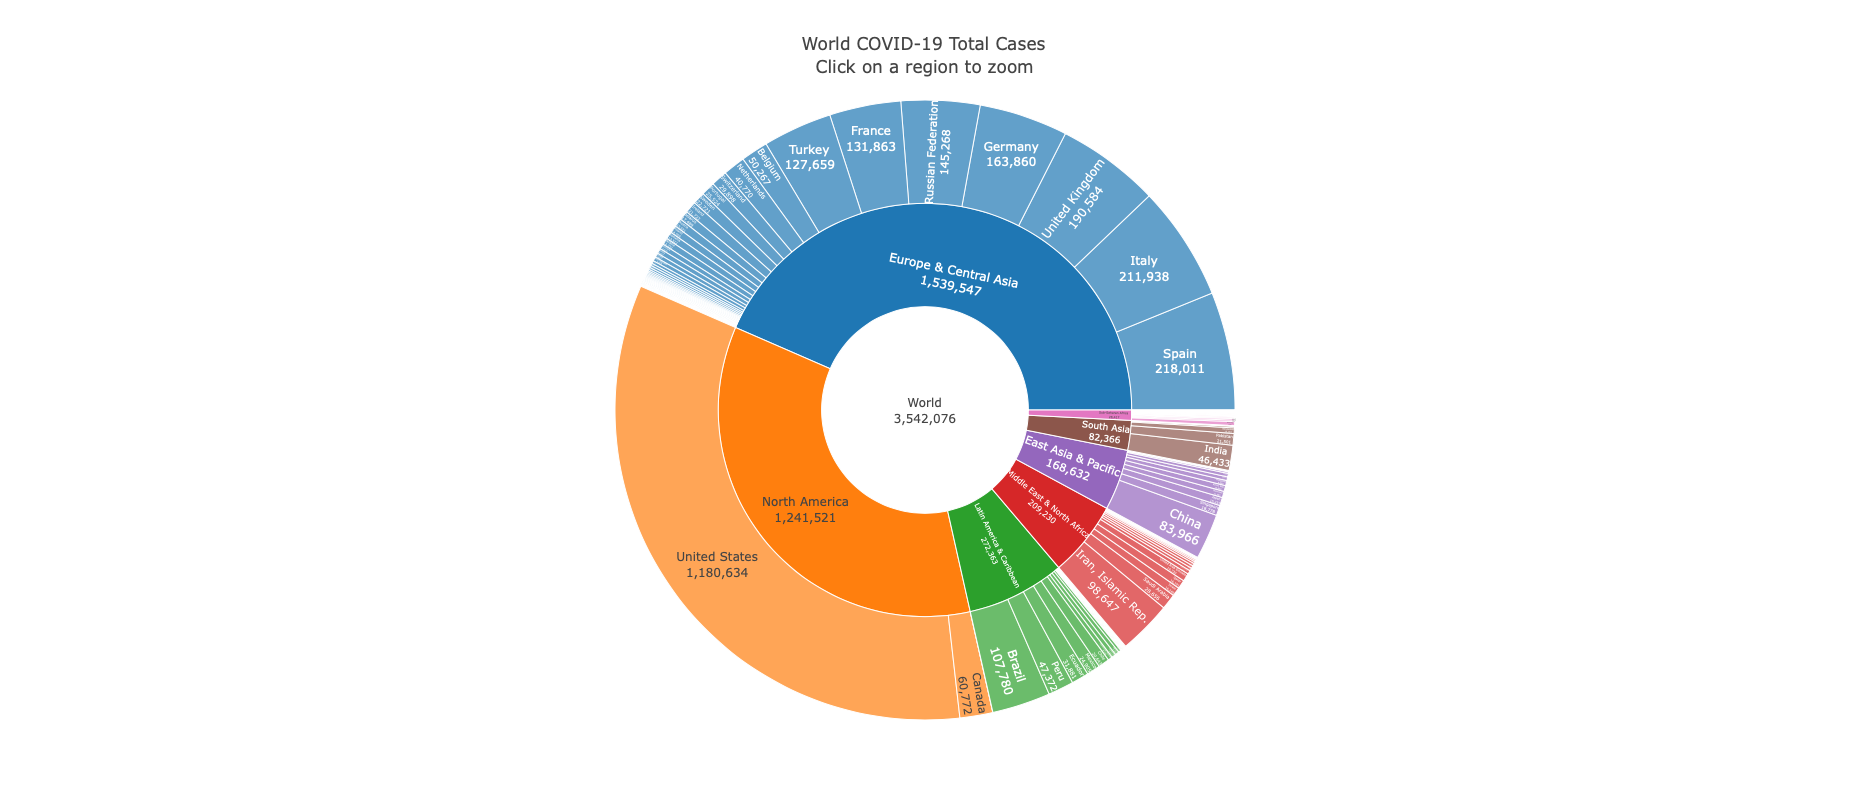

In [213]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = "total_cases"
wld_count = df_owid_wb['total_cases'].sum()

level1 = df_owid_wb.loc[:, ['region', 'country', column_to_display]].copy()
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))
# level1.head(1)

level2 = df_owid_wb.groupby('region')[column_to_display].sum().reset_index()[['region', 'region', column_to_display]]
level2.columns = columns
level2['parents'] = 'World'

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0
# level2.head(1)

level3 = pd.DataFrame({'parents': [''], 'labels': ['World'],
                       'values': [0.0], 'text': ['{:,.0f}'.format(wld_count)]})
# level3.head(1)

all_levels = pd.concat([level1, level2, level3], axis=0).reset_index(drop=True)

# And now we can plot the World Population
offline.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 Total Cases<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)

# New Cases

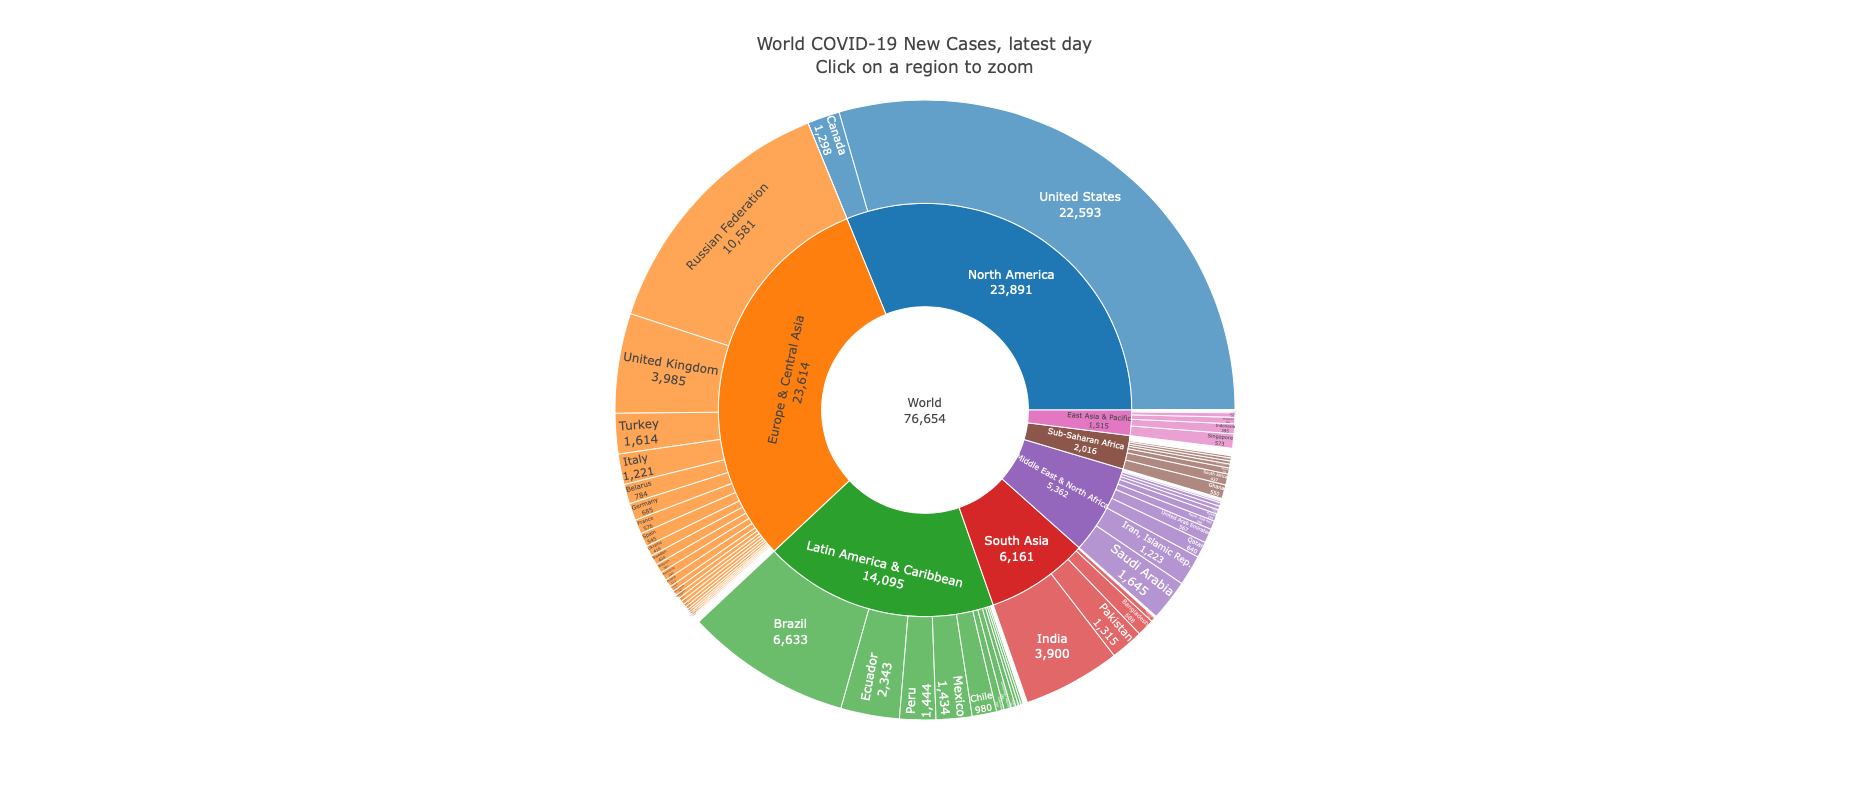

In [212]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = "new_cases"
wld_count = df_owid_wb[column_to_display].sum()

level1 = df_owid_wb.loc[:, ['region', 'country', column_to_display]].copy()
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))
# level1.head(1)

level2 = df_owid_wb.groupby('region')[column_to_display].sum().reset_index()[['region', 'region', column_to_display]]
level2.columns = columns
level2['parents'] = 'World'

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0
# level2.head(1)

level3 = pd.DataFrame({'parents': [''], 'labels': ['World'],
                       'values': [0.0], 'text': ['{:,.0f}'.format(wld_count)]})
# level3.head(1)

all_levels = pd.concat([level1, level2, level3], axis=0).reset_index(drop=True)

# And now we can plot the World Population
offline.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 New Cases, latest day<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)

# Tests per Million

In [158]:
df_owid_testing = pd.read_csv(f"{path_to_owid}/public/data/testing/covid-testing-all-observations.csv")
df_owid_testing.head(1)

,Entity,Date,Source URL,Source label,Notes,Cumulative total,Daily change in cumulative total,Cumulative total per thousand,Daily change in cumulative total per thousand,3-day rolling mean daily change,3-day rolling mean daily change per thousand,7-day rolling mean daily change,7-day rolling mean daily change per thousand
0,Argentina - tests performed,2020-04-08,https://www.argentina.gob.ar/sites/default/fil...,Government of Argentina,NaN,13330,NaN,0.295,NaN,NaN,NaN,NaN,NaN


In [159]:
df_owid_testing['country'] = df_owid_testing['Entity'].apply(lambda x: x.split("-")[0].strip())

In [160]:
df_owid_testing_latest = df_owid_testing.loc[df_owid_testing.Date == df_owid_testing.groupby('country')['Date'].transform('max')]
df_owid_testing_latest = df_owid_testing.loc[df_owid_testing['Cumulative total'] == df_owid_testing.groupby('country')['Cumulative total'].transform('max')]
len(df_owid_testing_latest)

82

In [161]:
df_owid_testing_latest.set_index('country', inplace=True, drop=False)

In [162]:
df_population.loc[df_population.country == 'Russian Federation', 'country'] = 'Russia'
df_population.loc[df_population.country == 'Iran, Islamic Rep.', 'country'] = 'Iran'
df_population.loc[df_population.country == 'Hong Kong SAR, China', 'country'] = 'Hong Kong'
df_population.loc[df_population.country == 'Slovak Republic', 'country'] = 'Slovakia'
df_population.loc[df_population.country == 'Korea, Rep.', 'country'] = 'South Korea'
df_population.loc[df_population.country == 'Taiwan, China', 'country'] = 'Taiwan'
df_population.set_index('country', inplace=True, drop=False)

In [163]:
df_owid_testing_latest_joined = df_owid_testing_latest.join(df_population.set_index('country'), how='inner')

In [164]:
set(df_owid_testing_latest.country) - set(df_owid_testing_latest_joined.country)

set()

In [165]:
set(df_owid_testing_latest.country) - set(df_owid_testing_latest_joined.country)

set()

In [166]:
df_population.loc[df_population.country.str.contains('Russia')]

,region,country,population,iso_code
country,,,,
Russia,Europe & Central Asia,Russia,144478050.0,RUS


/Users/chekanskiy/Documents/projects/covid-19-exploration/venv/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



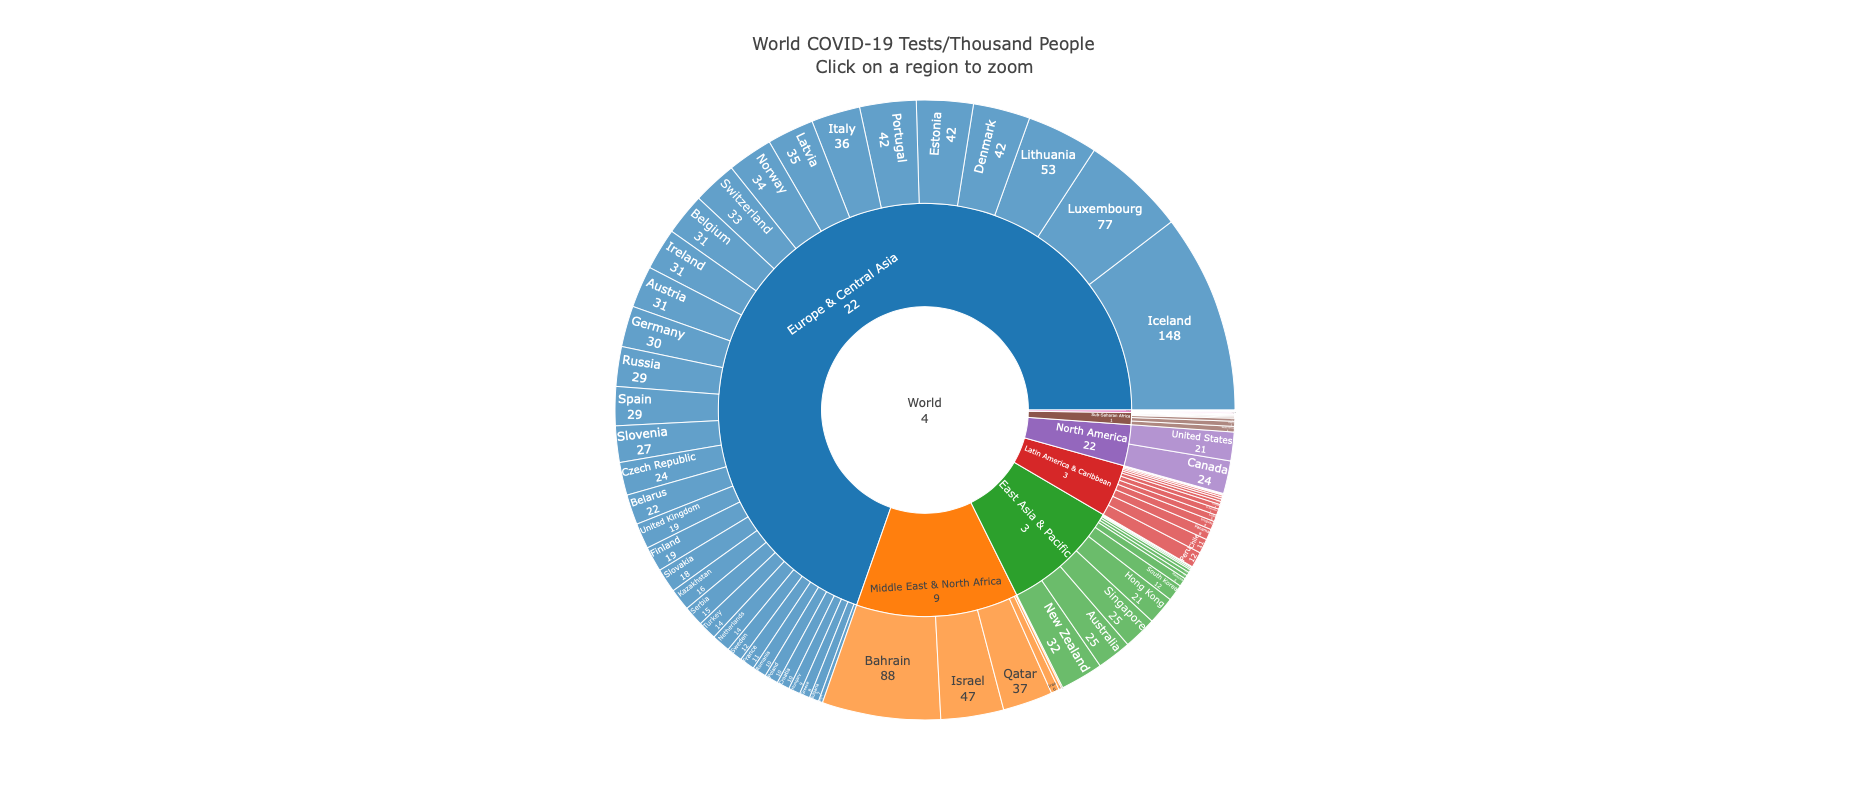

In [214]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = "Cumulative total per thousand"
wld_count = df_owid_testing_latest_joined['Cumulative total'].sum() / (population.loc['WLD'] / 1000)
df = df_owid_testing_latest_joined.copy()

level1 = df.loc[:, ['region', 'country', column_to_display]].copy()
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))
# level1.head(1)

# level2 = df.groupby('region')[column_to_display].sum().reset_index()[['region', 'region', column_to_display]]
# level2.columns = columns
# level2['parents'] = 'World'

total_cases = df_owid_testing_latest_joined.groupby('region')['Cumulative total'].sum().reset_index().set_index('region')
thousand_pop = (df_owid_testing_latest_joined.groupby('region')['population'].sum() / 1000).reset_index().set_index('region', drop=False)
region_cases_per_mil = thousand_pop.join(total_cases)
region_cases_per_mil[column_to_display] = region_cases_per_mil['Cumulative total'] / region_cases_per_mil['population'] 
level2 = region_cases_per_mil[['region', 'region', column_to_display]]
level2.columns = columns
level2['parents'] = 'World'

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0
# level2.head(1)



level3 = pd.DataFrame({'parents': [''], 'labels': ['World'],
                       'values': [0.0], 'text': ['{:,.0f}'.format(wld_count)]})
# level3.head(1)

all_levels = pd.concat([level1, level2, level3], axis=0).reset_index(drop=True)
# all_levels

# And now we can plot the World Population
offline.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 Tests/Thousand People<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)

# Total Tested

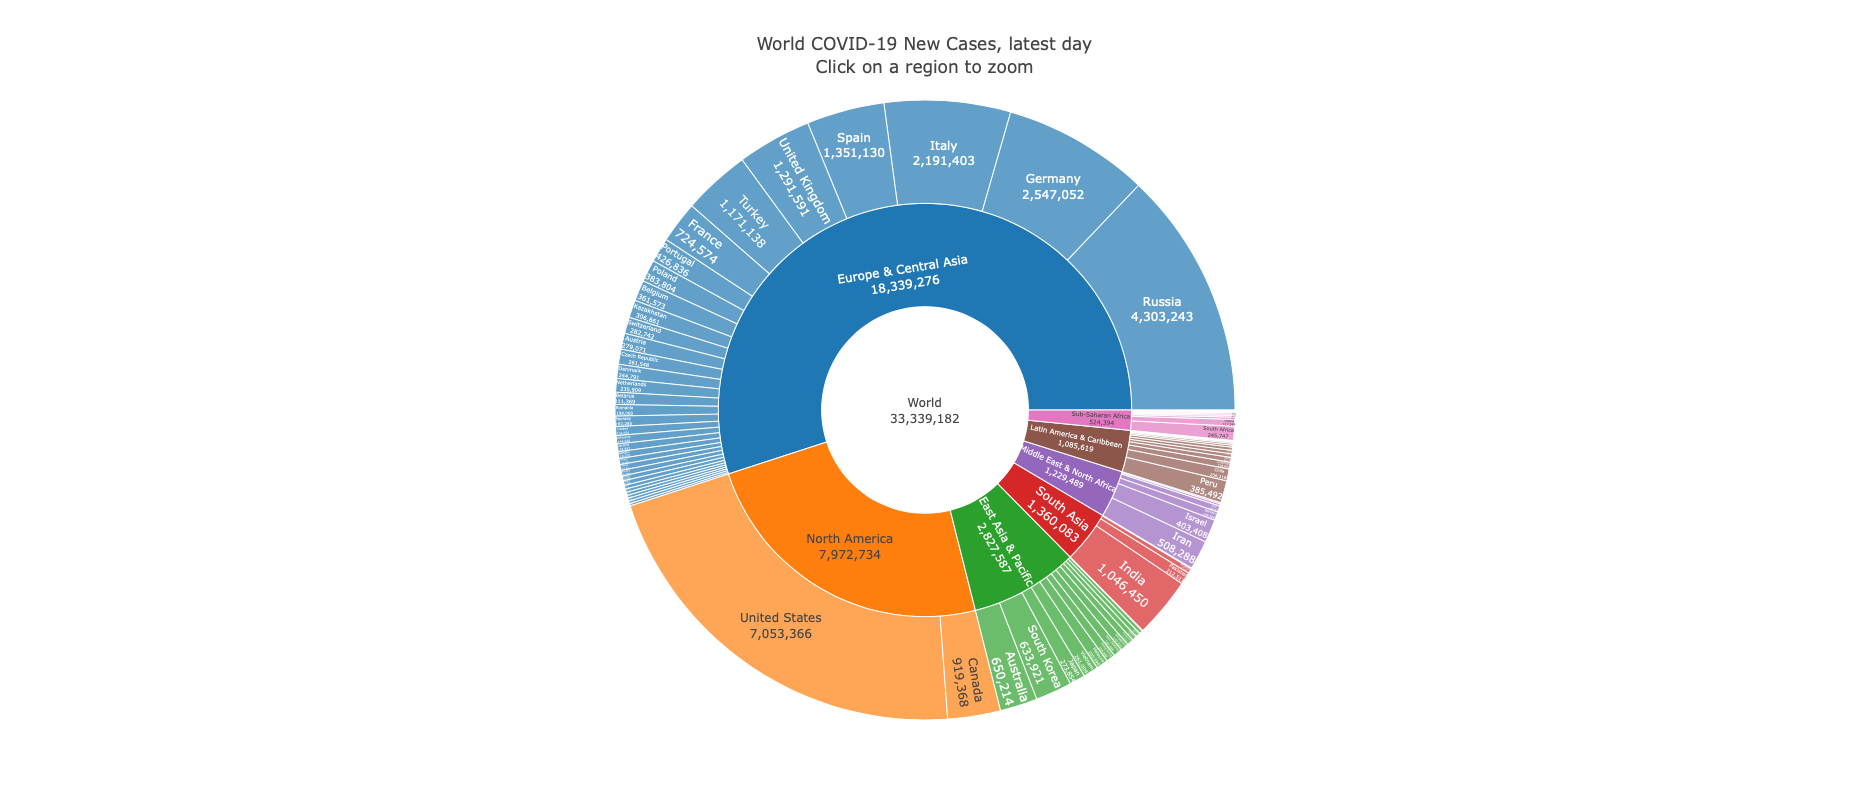

In [220]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = "Cumulative total"
wld_count = df_owid_testing_latest_joined[column_to_display].sum()

level1 = df_owid_testing_latest_joined.loc[:, ['region', 'country', column_to_display]].copy()
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))
# level1.head(1)

level2 = df_owid_testing_latest_joined.groupby('region')[column_to_display].sum().reset_index()[['region', 'region', column_to_display]]
level2.columns = columns
level2['parents'] = 'World'

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0
# level2.head(1)

level3 = pd.DataFrame({'parents': [''], 'labels': ['World'],
                       'values': [0.0], 'text': ['{:,.0f}'.format(wld_count)]})
# level3.head(1)

all_levels = pd.concat([level1, level2, level3], axis=0).reset_index(drop=True)

# And now we can plot the World Population
offline.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 New Cases, latest day<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)

# New Cases per 1000 population

/Users/chekanskiy/Documents/projects/covid-19-exploration/venv/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



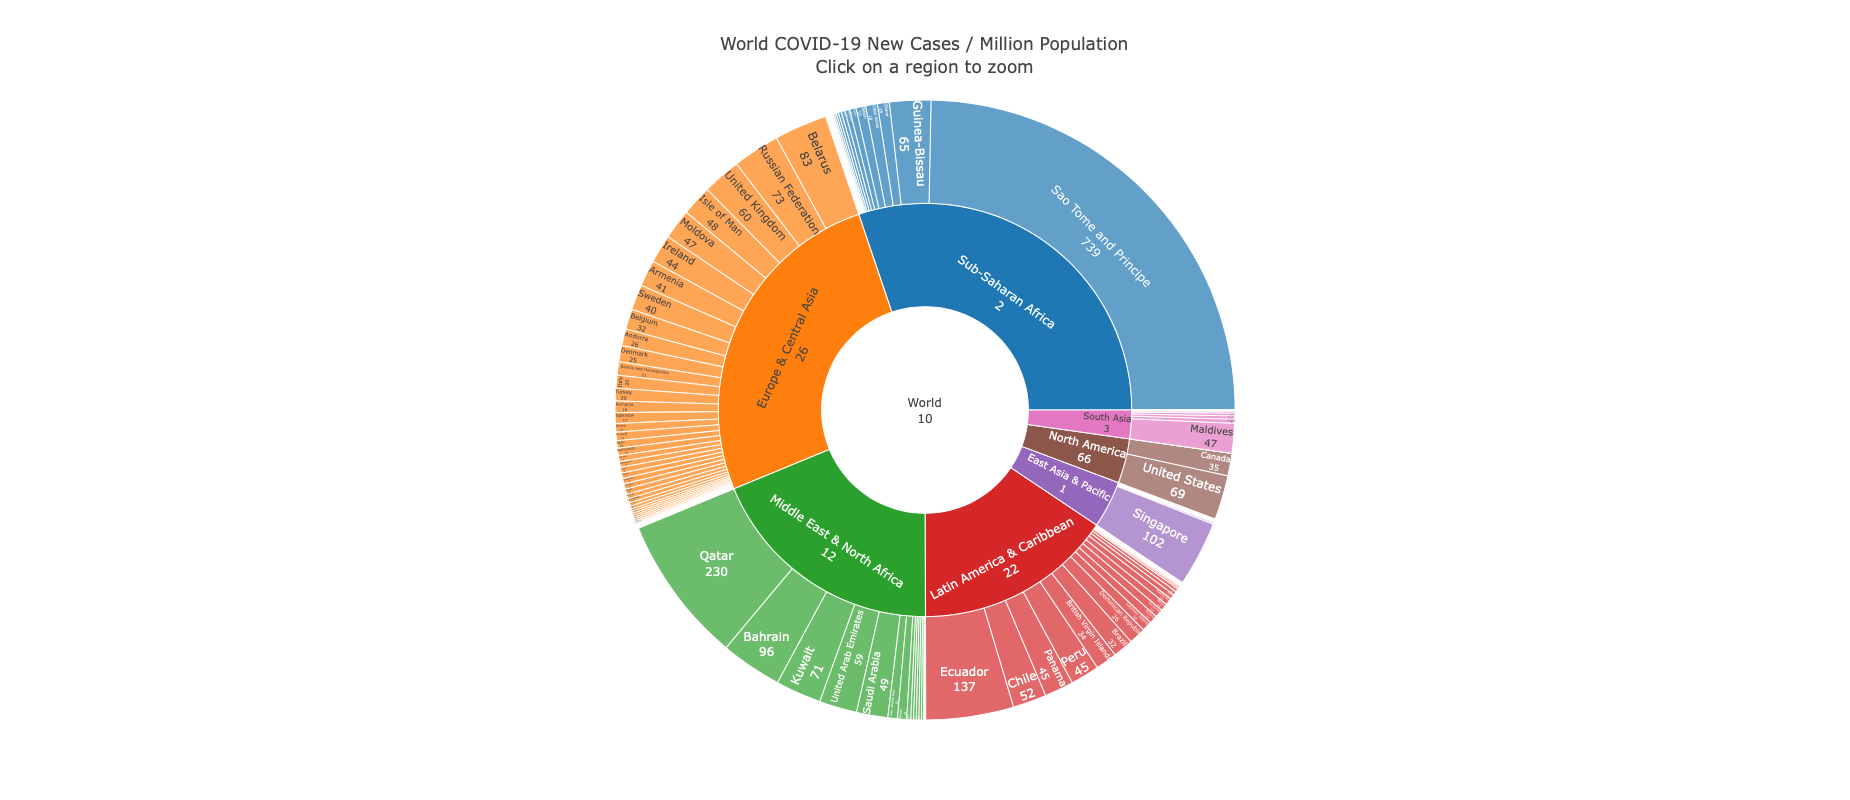

In [232]:
# The sunburst plot requires weights (values), labels, and parent (region, or World)
# We build the corresponding table here
columns = ['parents', 'labels', 'values']
column_to_display = "new_cases"
wld_count = df_owid_wb[column_to_display].sum() / (population.loc['WLD'] / 1000000)

level1 = df_owid_wb.copy()
level1['pop_thousands'] = level1['population'] / 1000000
level1[column_to_display] = level1[column_to_display] / level1['pop_thousands'] 
level1 = level1.loc[:, ['region', 'country', column_to_display]]
level1.columns = columns
level1['text'] = level1['values'].apply(lambda pop: '{:,.0f}'.format(pop))

total_cases = df_owid_wb.groupby('region')[column_to_display].sum().reset_index().set_index('region')
mil_pop = (df_owid_wb.groupby('region')['population'].sum() / 1000000).reset_index().set_index('region', drop=False)
region_cases_per_mil = mil_pop.join(total_cases)
region_cases_per_mil['total_cases_per_million'] = region_cases_per_mil[column_to_display] / region_cases_per_mil['population'] 
level2 = region_cases_per_mil[['region', 'region', 'total_cases_per_million']]
level2.columns = columns
level2['parents'] = 'World'

# move value to text for this level
level2['text'] = level2['values'].apply(lambda pop: '{:,.0f}'.format(pop))
level2['values'] = 0

level3 = pd.DataFrame({'parents': [''], 'labels': ['World'],
                       'values': [0.0], 'text': ['{:,.0f}'.format(wld_count)]})
# level3.head(1)

all_levels = pd.concat([level1, level2, level3], axis=0).reset_index(drop=True)


# And now we can plot the World Population
offline.iplot(dict(
    data=[dict(type='sunburst', hoverinfo='text', **all_levels)],
    layout=dict(title='World COVID-19 New Cases / Million Population<br>Click on a region to zoom',
                width=800, height=800)),
    validate=False)